<a href="https://colab.research.google.com/github/Guo-bot-1998/Appendicitis/blob/master/Appendicitis_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [1]:
!pip install timm

In [3]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import timm

ModuleNotFoundError: ignored

## 常用功能

In [36]:


def read_data(directory, shift=0, termi=10) -> dict[str, np.array]:
    """Reads all the .nii files in a given directory and returns a dictionary.

    The dictionary keys are the file names without the extension. The dictionary
    values are the corresponding numpy arrays.

    Args:
      directory: The directory containing the .nii files.
      shift: The number of files to skip at the beginning of the directory.
      termi: The number of files to be read in the directory.

    Returns:
      A dictionary of numpy arrays.
    """

    data_dict = {}
    k = 0
    ncut = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nii'):
                if (k<shift)       :
                  k += 1
                  continue
                file_path = os.path.join(root, file)
                nii_file =  nib.load(file_path)
                data = nii_file.get_fdata()
                data_dict[file.strip('.nii')] = data
                ncut +=  1
                if ncut == termi:
                  return data_dict
    return data_dict



def read_label(excel_path) -> pd.DataFrame:
  """Reads a csv file containing ground-truth.
    The csv file should have two columns: 'id' and 'label'.

    Args:
      excel_path: The path to the csv file.

    Returns:
      A pandas dataframe.
    """

  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    return df



def process_data(data:dict, labels:pd.DataFrame)\
 -> tuple[torch.tensor, torch.tensor, list[tuple[str, int]]]:
  """Process the data, get the id and number of each scan, and merge the images and labels.

  Args:
      data: The data of the scans
      labels: The labels of the scans

  Returns:
      A tuple of images, labels, and (id, # of cuts) of each scan
  """

  # 每個scan的id與數量
  scans_info = []
  # 圖片與對應label的tesnor
  images_list = []
  labels_list = []

  if dflabel.index.name != 'id':
    dflabel.set_index('id', inplace=True)
  for key, value in data.items():
    scans_info.append((key, value.shape[2]))
    scan  = dflabel.loc[dflabel.index.str.startswith(key+'_')]
    labels = np.array(scan['label'])

    images_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)
    labels_t = torch.from_numpy(labels)
    images_list.append(images_t)
    labels_list.append(labels_t)

  # 合併
  images = torch.cat(images_list, dim=0)
  labels = torch.cat(labels_list, dim=0)
  print(f"read {len(scans_info)} scans")

  return images, labels, scans_info


def argumenting(images, labels, n=5):
  where = (labels == True).nonzero(as_tuple=True)[0]
  bad_images = images[where]

  rep_imgs = bad_images.repeat(n, 1, 1, 1)
  rep_labels = torch.ones(rep_imgs.shape[0], dtype=labels.dtype)

  # 隨機插入argumented圖片
  nimg = images.shape[0]
  rnd_pos = torch.randperm(nimg)[:rep_imgs.shape[0]]
  images = torch.cat((images, rep_imgs), dim=0)
  images = images[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  # 對應對置插入標籤
  labels = torch.cat((labels, rep_labels), dim=0)
  labels = labels[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  return images, labels


def get_confusion(guess, truth):
  right = guess == truth
  wrong = torch.logical_not(right)
  TP = torch.sum(torch.logical_and(right, truth == torch.ones(right.shape)))
  TN = torch.sum(torch.logical_and(right, truth == torch.zeros(right.shape)))
  FN = torch.sum(torch.logical_and(wrong, truth == torch.ones(wrong.shape)))
  FP = torch.sum(torch.logical_and(wrong, truth == torch.zeros(wrong.shape)))
  cofu = torch.tensor([[TP, FP], [FN, TN]])
  return (TP,FP,FN,TN)


def custom_sort_key(val):
    parts = val.split('_')
    if len(parts) == 2 and parts[1].isdigit():
        return (parts[0], int(parts[1]))
    return (parts[0], -1)  # 使沒有_(數字)的id排最前面


def isgpu():
    """檢查是否有 CUDA 支持的 GPU"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        # raise("GPU not available")
    return device

In [33]:
rnd_pos = torch.randperm(4)
torch.cat((torch.arange(5), rnd_pos))

tensor([0, 1, 2, 3, 4, 1, 3, 0, 2])

In [4]:
device = isgpu()

GPU is available


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 路徑


In [10]:
cd /content/drive/MyDrive/AOCR2024

/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024


In [7]:
!pwd

/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024


# 處理資料

In [13]:
data = read_data("TrainValid_Image/train_data",termi=4)
dflabel = read_label("TrainValid_ground_truth.csv")
dflabel.set_index('id', inplace=True)

In [9]:
index_to_compare = 1  # Change this to the index you're interested in

# Find the key with the maximum value based on the specified index
max_key = max(data, key=lambda k: data[k][index_to_compare])

# Find the maximum value based on the specified index
max_value = data[max_key][index_to_compare]

# Print the result
print("Key with the maximum value:", max_key)
print(f"Maximum value at index {index_to_compare}:", max_value)

ValueError: ignored

In [14]:

# 轉換每個掃描中的圖像和標籤
images_list = []
labels_list = []

for value, label in processed:
    # value.shape 為 (512, 512, n)，label.shape 為 (n,)
    for i in range(value.shape[2]):
        image = value[:, :, i]
        image_tensor = torch.from_numpy(image).float().unsqueeze(0)  # 添加通道維度
        label_tensor = torch.tensor(label[i], dtype=torch.float32)
        # if(label_tensor==1): #Augmentation
        #   for j in range(20):
        #     images_list.append(image_tensor)
        #     labels_list.append(label_tensor)
        images_list.append(image_tensor)
        labels_list.append(label_tensor)

# 合併成批次數據
images = torch.stack(images_list)
labels = torch.stack(labels_list)


NameError: ignored

# 訓練 (Unet with only encoder)

In [ ]:
class FC(nn.Module):
    def __init__(self, in_channels):
        super(FC, self).__init__()

        # Encoder部分
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(1),  # Add BatchNorm after the first Conv2d
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Add BatchNorm after the first Conv2d
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Add BatchNorm after the second Conv2d
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Add BatchNorm after the third Conv2d
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Add BatchNorm after the fourth Conv2d
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(128 * 128 * 256, 1)  # x 和 y 是經過 encoder 處理後的特徵圖尺寸


    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

## 訓練 (EfficiencyNetV2_m)

In [ ]:
model_name = "tf_efficientnetv2_m"
pretrained_model = timm.create_model(model_name, pretrained=True)

# 修改輸入通道
pretrained_model.conv_stem = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)

# 修改輸出類別
num_classes = 1
pretrained_model.classifier = nn.Linear(pretrained_model.classifier.in_features, num_classes)

# 添加 Sigmoid 激活函數
pretrained_model = nn.Sequential(
    pretrained_model,
    nn.Sigmoid()
)

# 檢查模型結構
print(pretrained_model)


In [ ]:
from torch.utils.data import Dataset, DataLoader
num_epochs = 100
batch_size = 4
lr = 0.01
num_batches = len(images) // batch_size  #最後data不滿一個batch丟棄
# 初始化模型、損失函數和優化器
# model = FC(in_channels=1).to(device)
model = pretrained_model


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)
model.to(device)

running_loss_list = []
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Assuming you have 'images' and 'labels' as your original data
dataset = CustomDataset(images, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_images, batch_labels in dataloader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_images)
        outputs = outputs.squeeze()
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss_list.append(running_loss/len(dataloader))
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")

Epoch 1, Loss: 0.7089571100526035
Epoch 2, Loss: 0.5039287472583732
Epoch 3, Loss: 0.3691633912903271
Epoch 4, Loss: 0.4077927315120419


KeyboardInterrupt: ignored

In [ ]:
num_epochs = 10
batch_size = 16
lr = 0.001
num_batches = len(images) // batch_size  #最後data不滿一個batch丟棄
# 初始化模型、損失函數和優化器
model = FC(in_channels=1).to(device)
# model = pretrained_model


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)

running_loss_list = []

# 訓練循環
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i in range(num_batches):
        batch_images = images[i*batch_size:(i+1)*batch_size].to(device)
        batch_labels = labels[i*batch_size:(i+1)*batch_size].to(device)

        optimizer.zero_grad()
        outputs = model(batch_images)
        outputs = outputs.squeeze()
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss_list.append(running_loss/num_batches)
    print(f"Epoch {epoch+1}, Loss: {running_loss/num_batches}")


OutOfMemoryError: ignored

# Loss圖

ValueError: ignored

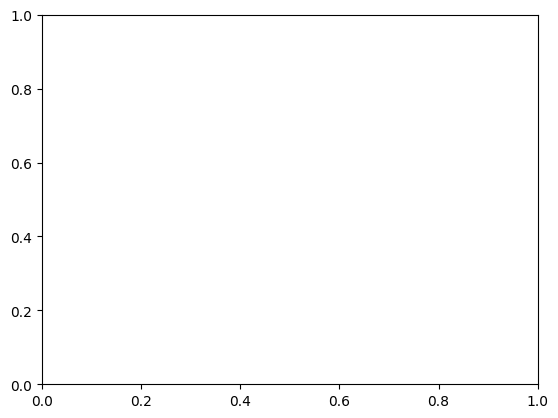

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,num_epochs+1), running_loss_list)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 儲存模型參數



In [ ]:
cd /content/drive/MyDrive/AOCR2024

/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024


In [ ]:
import json
appendix = input("請輸入要儲存的編號:")
modelname = model.__class__.__name__
filename = f"params/{modelname}/{modelname}{appendix}"
if os.path.isfile(filename+'.pth'):
    print(f"{filename}.pth exist.")
else:
    torch.save(model.state_dict(), f'{filename}.pth')

params = {
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'learning_rate': lr
}

if os.path.isfile(filename+'.json'):
    print(f"{filename}.json exist.")
else:
    with open(f'{filename}.json', 'w') as f:
        json.dump(params, f)

請輸入要儲存的編號:3


# 讀取模型參數

In [ ]:
import json
remove_digits = str.maketrans('', '', '0123456789')
modelname = input("請輸入要獲取模型檔名:")
filename = f"params/{modelname.translate(remove_digits)}/{modelname}"

if 'model' not in globals() or model.__class__.__name__ != modelname.translate(remove_digits):
  exec(f'model = {modelname.translate(remove_digits)}(in_channels=1).to(device)')

if not os.path.isfile(filename+'.pth'):
    print(f"{filename}.pth not exist.")
else:
    print(model.load_state_dict(torch.load(filename+'.pth')))
with open(f'{filename}.json', 'r') as f:
    params = json.load(f)

請輸入要獲取模型檔名:FC3
<All keys matched successfully>


# 評估


In [ ]:
data = read_data("TrainValid_Image/train_data",termi=4)
dflabel = read_label("TrainValid_ground_truth.csv")
dflabel.set_index('id', inplace=True)

In [ ]:
testimages,testlabels,info = process_data(data, dflabel)

In [ ]:
# 評估設置
num_epochs = params['num_epochs']
batch_size = params['batch_size']
num_batches = len(testimages) // batch_size  #最後data不滿一個batch丟棄

NameError: ignored

In [ ]:
model.eval()

predict_list = torch.tensor([]).to(device)
with torch.no_grad():  # 不更新梯度
    correct = 0
    total = 0
    for i in range(num_batches):
        batch_images = testimages[i*batch_size:(i+1)*batch_size].to(device)
        batch_labels = testlabels[i*batch_size:(i+1)*batch_size].to(device)

        outputs = model(batch_images)
        predicted = (outputs.squeeze() > 0.5).int()
        predict_list = torch.cat((predict_list,predicted),0)


predict_listq = predict_list.cpu()



In [ ]:
TP,FP,FN,TN = get_confusion(predict_listq, testlabels[:len(predict_list)])
print(f"\n\
     真實值\n\
預  +-----+-----+\n\
測| TP: {TP}| FP: {FP}|\n\
值| FN: {FN}| TN: {TN}|\n\
    +-----+-----+ \n\
 \n")

recall = TP/(TP + FN)
precision = TP/(TP + FP)
recall = 0 if torch.isnan(recall) else recall.item()
precision = 0 if torch.isnan(precision) else precision.item()
F1 = 0 if recall + precision == 0 else  (2*recall*precision/(recall+precision))

print(f"{recall=}\n{precision=}\n{F1=}\n")


     真實值
預  +-----+-----+
測| TP: 651| FP: 29|
值| FN: 231| TN: 897|
    +-----+-----+ 
 

recall=0.738095223903656
precision=0.9573529362678528
F1=0.8335467240448838



# 輸出至submission.csv

In [ ]:
predict_list = predict_listq.numpy()

## 還原id與對應label，假設key按照scan輸入順序排列,每個key對應的scan的cuts數是nslice
output = {}
key_th = 0  #第幾個scan的key
ii = 0   #每個key輪到第幾個
nslice = nslices[key_th]  #對應scan的cut數
for i in range(len(predict_list)):
  if (ii >= nslice):
    output[keys[key_th]] = int(predict_list[i-nslice:i].any())
    key_th += 1
    ii = 0
    nslice = nslices[key_th]
  label = predict_list[i]
  output[keys[key_th]+f'_{ii}'] = predict_list[i]
  ii += 1
output[keys[key_th]] = int(predict_list[i-ii:].any()) #補上最後一個scan判斷

output = list(output.items())
dfout = pd.DataFrame(output)
dfout.columns = ['id', 'label']
dfout = dfout.sort_values(by='id', key=lambda x: x.map(custom_sort_key))
dfout.to_csv('submission.csv', index=False)

IndexError: ignored

In [ ]:
predict_list = predict_listq.numpy()

## 還原id與對應label，假設key按照scan輸入順序排列,每個key對應的scan的cuts數是nslice
output = {}
k = 0  #第幾個scan
ii = 0   #每個key輪到第幾個
id, nslice = info[k][0], info[k][1]
for i in range(len(predict_list)):

  if (ii >= nslice):
    #該換下一個scan了
    output[id] = int(predict_list[i-nslice:i].any()) #評估方式
    k += 1
    ii = 0
    id, nslice = info[k][0], info[k][1]

  label = predict_list[i]
  output[id+f'_{ii}'] = predict_list[i]
  ii += 1

output[id] = int(predict_list[i-ii:].any()) #補上最後一個scan評估

output = list(output.items())
dfout = pd.DataFrame(output)
dfout.columns = ['id', 'label']
dfout = dfout.sort_values(by='id', key=lambda x: x.map(custom_sort_key))
dfout.to_csv('submission.csv', index=False)

In [ ]:
dfout

NameError: ignored